In [1]:
%matplotlib inline
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from IPython.display import display # to display images

In [2]:
class ConfigClass():
    train_dir = '/kaggle/input/train-test-for-each-class/data/test/'    # it shows the train directory
    test_dir = '/kaggle/input/train-test-for-each-class/data/training/'       # it shows the test directory
    train_batch_size = 16    #defines the number of samples that will be propagated through the network.
    train_num_epochs = 10    #it shows the number of epochs will be used in training.

In [3]:
class SiameseDataset(Dataset): 
    def __init__(self, image_folder, transform = None, invert = False, showimage = False, testing= False):
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert
        self.showimage = showimage
        self.testing = testing
        
    def __getitem__(self, index):
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)
        #Image.open(sample_1)
        if same_class:
            while True:
                #keep looping till the same class image is found
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break
        counter44 = 1
        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")
        if self.showimage:
            counter44 = counter44+1
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
        if self.testing:
            return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32)) ,torch.from_numpy(np.array([sample_1[1]], dtype = np.float32)), torch.from_numpy(np.array([sample_2[1]], dtype = np.float32)) 
        else:
            return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32))
        
    def __len__(self):
        return len(self.image_folder.imgs)
    

In [4]:
image_folder = dataset.ImageFolder(root=ConfigClass.train_dir)
siamese_dataset = SiameseDataset(image_folder=image_folder, 
                                 transform=transforms.Compose([transforms.Resize((250, 250)), transforms.ToTensor()]), 
                                 invert=False , showimage = False)

In [5]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [6]:
#dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8)
#data_iter = iter(dataloader)
#vis_batch = next(data_iter)
#merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
#imshow(torchvision.utils.make_grid(merged))
#vis_batch[2].numpy()

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(4)
        self.batch_norm2 = nn.BatchNorm2d(8) 
        self.fc1 = nn.Linear(8 * 250 * 250, 500) 
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 4)
        
    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x))))
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x))))        
        x = self.batch_norm2(self.relu(self.conv3(self.reflection_pad(x))))
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))        
        x = self.fc3(x)
        return x
        
    def forward(self, input1, input2):
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)     
        
        return output1, output2

In [8]:
class ConstrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ConstrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2, keepdim=True)
        contrastive_loss = torch.mean((1 - label)*torch.pow(distance, 2)
                                      + (label)*torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        
        return contrastive_loss

In [9]:
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=ConfigClass.train_batch_size)
model = SiameseNetwork().cuda()
criterion = ConstrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration = 0

Epoch: 0 	 Loss: 51.13101577758789
Epoch: 0 	 Loss: 179.76312255859375
Epoch: 1 	 Loss: 33.57561492919922
Epoch: 1 	 Loss: 52.145851135253906
Epoch: 2 	 Loss: 19.880699157714844
Epoch: 2 	 Loss: 16.18477439880371
Epoch: 3 	 Loss: 12.675785064697266
Epoch: 3 	 Loss: 8.222039222717285
Epoch: 4 	 Loss: 18.687976837158203
Epoch: 4 	 Loss: 7.92778205871582
Epoch: 5 	 Loss: 21.50313949584961
Epoch: 5 	 Loss: 4.692627906799316
Epoch: 6 	 Loss: 9.332866668701172
Epoch: 6 	 Loss: 1.3542509078979492
Epoch: 7 	 Loss: 4.647048473358154
Epoch: 7 	 Loss: 4.383002758026123
Epoch: 8 	 Loss: 0.9432910680770874
Epoch: 8 	 Loss: 1.4819406270980835
Epoch: 9 	 Loss: 1.1991569995880127
Epoch: 9 	 Loss: 1.6301943063735962


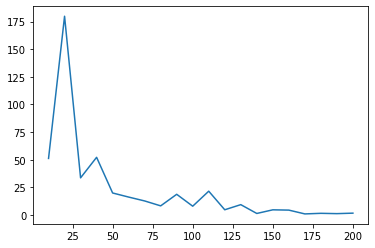

In [10]:
for epoch in range(ConfigClass.train_num_epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, label = data
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = model(input1, input2)
        contrastive_loss = criterion(output1, output2, label)
        contrastive_loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
            iteration += 10
            loss_history.append(contrastive_loss.item())
            counter.append(iteration)
            
show_plot(counter, loss_history)

They are not in the same class


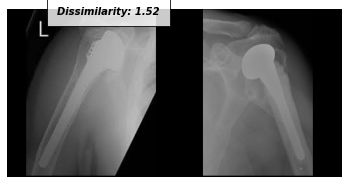

They are not in the same class


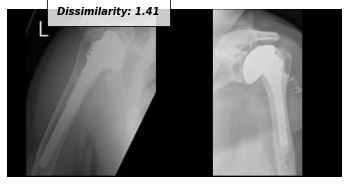

They are not in the same class


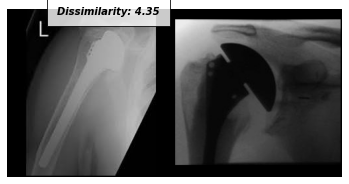

They are in the same class


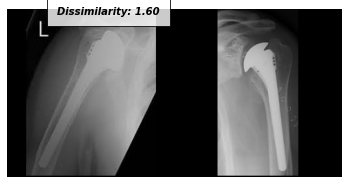

They are in the same class


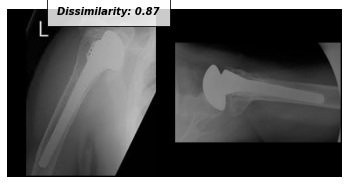

They are in the same class


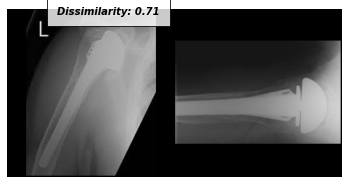

They are not in the same class


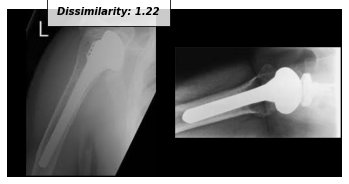

They are in the same class


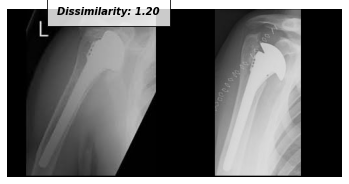

They are in the same class


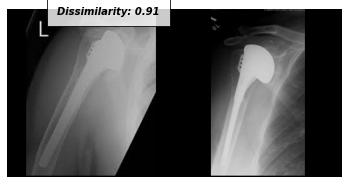

They are not in the same class


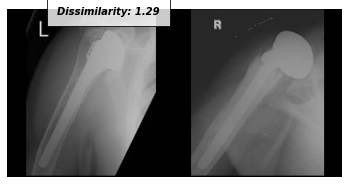

In [11]:
test_folder = dataset.ImageFolder(root=ConfigClass.test_dir)
siamese_dataset = SiameseDataset(image_folder=test_folder, 
                                 transform=transforms.Compose([transforms.Resize((250, 250)), transforms.ToTensor()]), 
                                 invert=False, showimage= True, testing = True)

dataloader = DataLoader(siamese_dataset, num_workers=6, batch_size=1, shuffle=True)
data_iter = iter(dataloader)
img0, _, label0, img0_label,_ = next(data_iter)
for i in range(10):
    _, img1, label,_, img1_label = next(data_iter)
    merged = torch.cat((img0,img1), 0)
    output1, output2 = model(Variable(img0).cuda(), Variable(img1).cuda())
    if img0_label == img1_label:
        print('They are in the same class')
    else:
        print('They are not in the same class')
    distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(merged), 'Dissimilarity: {:.2f}'.format(distance.item()))
